# Topic modeling on ireland-timeline textual data

## Importing libraries

In [1]:
# import sys
# sys.path.append("/home/jovyan/work/sem-covid/")
# sys.path = list(set(sys.path))
#
# import os
# os.getcwd()
# os.chdir('/home/jovyan/work/sem-covid/')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import spacy
nlp = spacy.load("en_core_web_sm")

import gensim
import pyLDAvis.gensim_models

from gensim.models import LdaModel, LsiModel
from sem_covid.entrypoints.notebooks.topic_modeling.topic_modeling_wrangling.topic_visualizer import generate_wordcloud
from sem_covid.services.data_registry import Dataset
from sem_covid.services.sc_wrangling.data_cleaning import clean_text_from_specific_characters, clean_fix_unicode, \
    clean_remove_currency_symbols, clean_remove_emails, clean_remove_urls
from sem_covid.entrypoints.notebooks.topic_modeling.topic_modeling_wrangling.token_management import filter_stop_words,\
    filter_pos, filter_stop_words_on_a_span_list, select_pos, spacy_stop_words

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=n

## Fetching data from document store

In [15]:
ireland_timeline = Dataset.IRELAND_ACTION_TIMELINE.fetch()

ireland_timeline.fillna(value="", inplace=True)

document_corpus = ireland_timeline['title'].map(str) + '. ' + \
                  ireland_timeline['content'].map(str)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



5

## Data preprocessing

- data cleanup
- turn corpus into spacy Docs

In [3]:
unused_characters = ["\\r", ">", "\n", "\\", "<", "''", "%", "...", "\'", '"', "(", "\n", "*", "1)", "2)", "3)",
                     "[", "]", "-", "_", "\r"]

document_corpus = document_corpus.apply(clean_text_from_specific_characters, characters=unused_characters)
document_corpus = document_corpus.apply(clean_fix_unicode)
document_corpus = document_corpus.apply(clean_remove_urls)
document_corpus = document_corpus.apply(clean_remove_emails)
document_corpus = document_corpus.apply(clean_remove_currency_symbols)
spacy_corpus = document_corpus.apply(nlp)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Preparing few corpora

Filter document tokens. Select only the needed/interesting tokens for Topic modeling:
   - all words
   - nouns
   - verbs
   - noun phrases

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



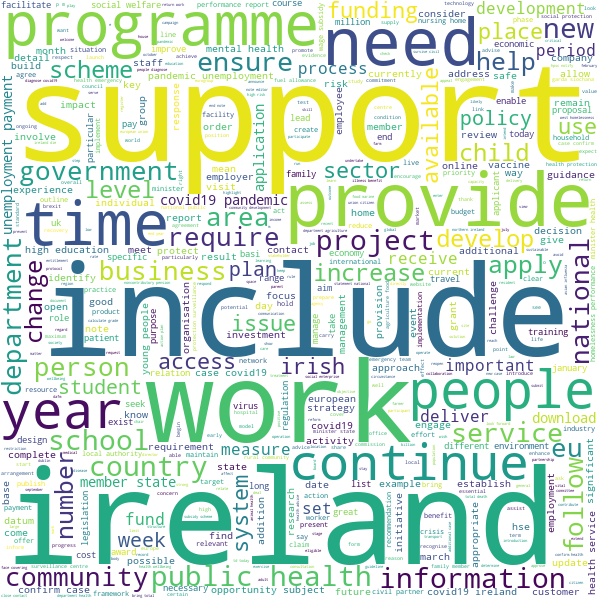

In [4]:
word_corpus = spacy_corpus.apply(filter_stop_words, stop_words=spacy_stop_words)
word_corpus = word_corpus.apply(filter_pos, pos="PUNCT")
word_corpus = word_corpus.apply(lambda x: list(map(lambda docs: docs.lemma_,x)))

generate_wordcloud(" ".join( [" ".join(doc) for doc in word_corpus]) )

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



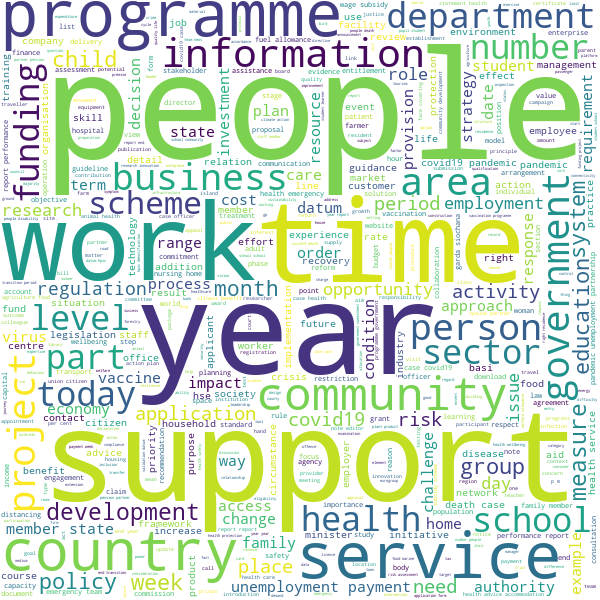

In [5]:
noun_corpus = spacy_corpus.apply(select_pos, pos="NOUN")
noun_corpus = noun_corpus.apply(lambda x: list(map(lambda docs: docs.lemma_,x)))

generate_wordcloud(" ".join( [" ".join(doc) for doc in noun_corpus]) )

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



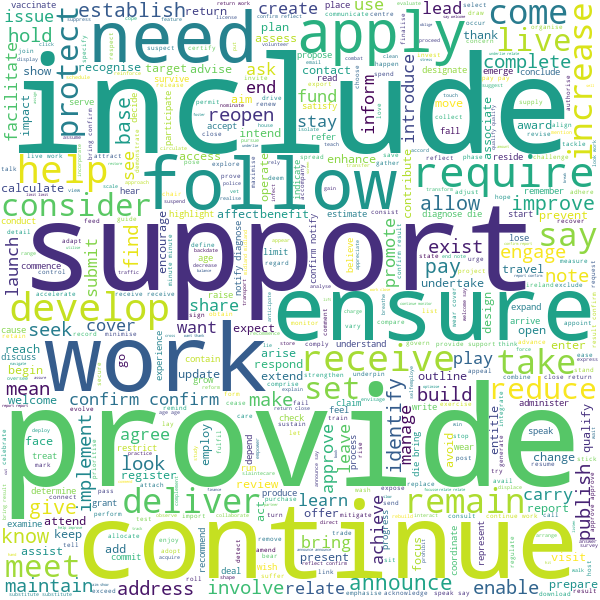

In [6]:
verb_corpus = spacy_corpus.apply(select_pos, pos="VERB")
verb_corpus = verb_corpus.apply(filter_stop_words)
verb_corpus = verb_corpus.apply(lambda x: list(map(lambda docs: docs.lemma_,x)))

generate_wordcloud(" ".join( [" ".join(doc) for doc in verb_corpus]) )

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



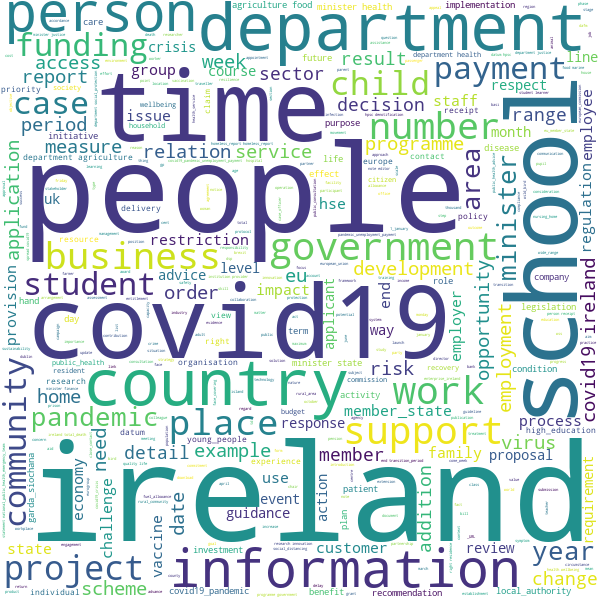

In [7]:
noun_phrase_corpus = spacy_corpus.apply(lambda x: x.noun_chunks)
noun_phrase_corpus = noun_phrase_corpus.apply(filter_stop_words_on_a_span_list)

generate_wordcloud(" ".join( [" ".join(doc) for doc in noun_phrase_corpus]) )

## Train LDA + LSI models

- create_dag a dictionary and a corpus with each corpora
- train LDA models
- train LSI models
- visualize the results (LDA)

In [8]:
word_dictionary = gensim.corpora.Dictionary(word_corpus)
noun_dictionary = gensim.corpora.Dictionary(noun_corpus)
verb_dictionary = gensim.corpora.Dictionary(verb_corpus)
noun_phrases_dictionary = gensim.corpora.Dictionary(noun_phrase_corpus)

word_gensim_corpus = [word_dictionary.doc2bow(docs) for docs in word_corpus]
noun_gensim_corpus = [noun_dictionary.doc2bow(docs) for docs in noun_corpus]
verb_gensim_corpus = [verb_dictionary.doc2bow(docs) for docs in verb_corpus]
noun_phrases_gensim_corpus = [noun_phrases_dictionary.doc2bow(docs) for docs in noun_phrase_corpus]

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [9]:
word_lda_model = LdaModel(corpus=word_gensim_corpus, num_topics=5, id2word=word_dictionary, chunksize=30, random_state=40)
noun_lda_model = LdaModel(corpus=noun_gensim_corpus, num_topics=5, id2word=noun_dictionary, chunksize=30, random_state=40)
verb_lda_model = LdaModel(corpus=verb_gensim_corpus, num_topics=4, id2word=verb_dictionary, chunksize=20, random_state=40)
noun_phrases_lda_model = LdaModel(corpus=noun_phrases_gensim_corpus, num_topics=5, id2word=noun_phrases_dictionary, chunksize=30, random_state=40)

word_lsa_model = LsiModel(corpus=word_gensim_corpus, num_topics=6, id2word=word_dictionary, chunksize=300)
noun_lsa_model = LsiModel(corpus=noun_gensim_corpus, num_topics=6, id2word=noun_dictionary, chunksize=300)
verb_lsa_model = LsiModel(corpus=verb_gensim_corpus, num_topics=6, id2word=verb_dictionary, chunksize=300)
noun_phrases_lsa_model = LsiModel(corpus=noun_phrases_gensim_corpus, num_topics=6, id2word=noun_phrases_dictionary, chunksize=300)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [10]:
pyLDAvis.enable_notebook()
word_visualization = pyLDAvis.gensim_models.prepare(word_lda_model, word_gensim_corpus, word_dictionary)
word_visualization

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.087884  0.107292       1        1  31.746466
2      0.104133 -0.011247       2        1  20.469119
4     -0.022864 -0.201030       3        1  16.736353
1      0.051252  0.037860       4        1  15.630879
3     -0.220405  0.067126       5        1  15.417182, topic_info=             Term         Freq        Total Category  logprob  loglift
87           case  1186.000000  1186.000000  Default  30.0000  30.0000
358        person  1278.000000  1278.000000  Default  29.0000  29.0000
179            eu  1011.000000  1011.000000  Default  28.0000  28.0000
451         state  1539.000000  1539.000000  Default  27.0000  27.0000
1947    residence   566.000000   566.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
378    protection   191.197799   581.838675   Topic5  -5.4311   0.7568
1050            /   219.883584  1315.347647   Topic5  -5.2913   0.0809
272       ireland   226.892401  2039.812750   Topic5  -5.2600  -0.3264
259   information   196.586187   812.966482   Topic5  -5.4033   0.4501
310       measure   188.956400   621.404541   Topic5  -5.4429   0.6792

[418 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
1050      1  0.160414     /
1050      2  0.320067     /
1050      3  0.317026     /
1050      4  0.035732     /
1050      5  0.167256     /
...     ...       ...   ...
536       1  0.297480  year
536       2  0.227256  year
536       3  0.307234  year
536       4  0.127770  year
536       5  0.040965  year

[1136 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 5, 2, 4])

In [11]:
noun_visualization = pyLDAvis.gensim_models.prepare(noun_lda_model, noun_gensim_corpus, noun_dictionary)
noun_visualization

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.019074 -0.100507       1        1  28.993178
3      0.145453  0.065621       2        1  28.281086
1      0.042597 -0.164652       3        1  16.778051
0      0.092290  0.134871       4        1  15.690528
2     -0.261266  0.064668       5        1  10.257158, topic_info=             Term         Freq        Total Category  logprob  loglift
308    regulation   781.000000   781.000000  Default  30.0000  30.0000
82         health  1930.000000  1930.000000  Default  29.0000  29.0000
134       payment   891.000000   891.000000  Default  28.0000  28.0000
158      research   838.000000   838.000000  Default  27.0000  27.0000
384       project   916.000000   916.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
132          part    88.260471   436.255009   Topic5  -5.0960   0.6793
2202       spouse    72.684069   167.444145   Topic5  -5.2902   1.4427
127        office    73.989631   216.377455   Topic5  -5.2724   1.2041
6     application    76.111488   460.681208   Topic5  -5.2441   0.4767
82         health    79.705603  1930.979143   Topic5  -5.1980  -0.9102

[381 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1089      1  0.028060           .
1089      4  0.028060           .
1089      5  0.925972           .
1001      2  0.011969         act
1001      3  0.005984         act
...     ...       ...         ...
225       3  0.439235        year
225       4  0.086528        year
225       5  0.009889        year
1284      3  0.934179  yearonyear
1330      5  0.939900        zone

[952 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 2, 1, 3])

In [12]:
verb_visualization = pyLDAvis.gensim_models.prepare(verb_lda_model, verb_gensim_corpus, verb_dictionary)
verb_visualization

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.009598  0.122905       1        1  33.676309
1      0.083983  0.052801       2        1  25.725546
2     -0.215940 -0.046956       3        1  24.473174
3      0.122359 -0.128750       4        1  16.124971, topic_info=         Term        Freq        Total Category  logprob  loglift
840    reside  353.000000   353.000000  Default  30.0000  30.0000
5       apply  444.000000   444.000000  Default  29.0000  29.0000
936   satisfy  188.000000   188.000000  Default  28.0000  28.0000
113  restrict  175.000000   175.000000  Default  27.0000  27.0000
791    regard  171.000000   171.000000  Default  26.0000  26.0000
..        ...         ...          ...      ...      ...      ...
46     ensure   90.290565   525.224945   Topic4  -4.4791   0.0640
126     speak   50.479784   116.769441   Topic4  -5.0605   0.9862
64    include   85.749847  1006.491334   Topic4  -4.5307  -0.6380
244      take   65.274413   333.241470   Topic4  -4.8035   0.1945
222   require   59.185083   558.090214   Topic4  -4.9014  -0.4190

[297 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
342       2  0.948334      absorb
343       1  0.152461  accelerate
343       2  0.827645  accelerate
343       3  0.021780  accelerate
251       1  0.174495         add
...     ...       ...         ...
152       2  0.212551        work
152       3  0.166456        work
152       4  0.161334        work
720       2  0.078950      worsen
720       4  0.947399      worsen

[600 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

In [13]:
noun_phrases_visualization = pyLDAvis.gensim_models.prepare(noun_phrases_lda_model, noun_phrases_gensim_corpus, noun_phrases_dictionary)
noun_phrases_visualization


/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.056727 -0.152863       1        1  25.363621
3     -0.108562 -0.069639       2        1  24.127809
4      0.081201  0.068111       3        1  20.356727
0     -0.140472  0.085751       4        1  18.005805
1      0.111107  0.068640       5        1  12.146039, topic_info=             Term        Freq        Total Category  logprob  loglift
180        person  926.000000   926.000000  Default  30.0000  30.0000
1003       school  562.000000   562.000000  Default  29.0000  29.0000
397    regulation  406.000000   406.000000  Default  28.0000  28.0000
1659    residence  349.000000   349.000000  Default  27.0000  27.0000
59        covid19  752.000000   752.000000  Default  26.0000  26.0000
...           ...         ...          ...      ...      ...      ...
139       ireland   66.854820  1071.129028   Topic5  -5.3866  -0.6658
436   application   45.393439   214.603497   Topic5  -5.7737   0.5547
180        person   62.050977   926.606690   Topic5  -5.4612  -0.5954
2826  agriculture   38.390707   123.160614   Topic5  -5.9413   0.9425
38           case   39.428610   392.789225   Topic5  -5.9146  -0.1906

[373 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1684      1  0.995274        14_day
2630      1  0.963140       18_year
2630      3  0.021890       18_year
5016      3  0.922990        3_year
3188      1  0.027042       absence
...     ...       ...           ...
276       3  0.211298          year
276       4  0.190850          year
276       5  0.081793          year
2243      1  0.937860  young_people
2243      3  0.048510  young_people

[798 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 5, 1, 2])